In [164]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import geopandas as gpd
from bs4 import BeautifulSoup 
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from functools import reduce
from glob import glob
import copy
from math import ceil
from scipy.stats import uniform
from scipy.stats import qmc
from scipy.stats import sobol_indices

import importlib

import utils.data
import utils.thresholds
import utils.plotting_utils
import utils.HRI

importlib.reload(utils.data)
importlib.reload(utils.thresholds)
importlib.reload(utils.plotting_utils)
importlib.reload(utils.HRI)

import utils.data as Data
import utils.thresholds as Thresholds
import utils.plotting_utils as PlottingUtils
import utils.HRI as HRI

- The [Sobol’ method](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.sobol_indices.html) is a variance-based Sensitivity Analysis which obtains the contribution of each parameter to the variance of the quantities of interest (QoIs; i.e., the outputs of func).
    - Negative Sobol’ values are due to numerical errors. Increasing the number of points n should help.
    - The number of sample required to have a good analysis increases with the dimensionality of the problem. e.g. for a 3 dimension problem, consider at minima n >= 2**12. The more complex the model is, the more samples will be needed.
    - Even for a purely additive model, the indices may not sum to 1 due to numerical noise.

- First-order: “What matters by itself?”
- Total-order: “What matters if I remove it from the system?”

Given the deterministic structure of the heat risk index, Sobol sensitivity analysis is not used to infer causal drivers, but rather to evaluate the robustness of the index to uncertainty in normative weighting choices. First- and total-order Sobol indices quantify the extent to which variation in individual weights—and their trade-offs—contribute to variability in the resulting HRI values.

# Import data

In [2]:
risk_imported_df = Data.import_data(data_dir = r"Risk_Data_Imputed")
risk_df = Data.consolidate_df(risk_imported_df, normalise=None)
risk_df

risk_dfs = dict()
for normalise in ["perc","min_max","max_scaling"]:
    risk_dfs[normalise] = Data.normalisation_imputation_df(risk_imported_df, normalise=normalise)

risk_dfs

{'perc': {'raw_df': {'DayTime': {'Capacity':                  PLN_AREA_N  AC Ownership  \
    0                ANG MO KIO     22.222222   
    1                     BEDOK     48.888889   
    2                    BISHAN     66.666667   
    3                  BOON LAY           NaN   
    4               BUKIT BATOK     35.555556   
    5               BUKIT MERAH     31.111111   
    6             BUKIT PANJANG     42.222222   
    7               BUKIT TIMAH     73.333333   
    8   CENTRAL WATER CATCHMENT           NaN   
    9                    CHANGI     90.000000   
    10               CHANGI BAY      6.666667   
    11            CHOA CHU KANG     53.333333   
    12                 CLEMENTI     57.777778   
    13            DOWNTOWN CORE     71.111111   
    14                  GEYLANG     20.000000   
    15                  HOUGANG     37.777778   
    16              JURONG EAST     24.444444   
    17              JURONG WEST     26.666667   
    18                  KALL

# Import weights

In [3]:
daytime_weights = pd.read_csv(Data.DAYTIME_WEIGHTS_FP)
nighttime_weights = pd.read_csv(Data.NIGHTTIME_WEIGHTS_FP)
petal_weights = pd.read_csv(Data.PETAL_WEIGHTS_FP)
thresholds = pd.read_csv(Data.THRESHOLDS_FP)
print(f"Number of petal weights: {len(petal_weights)}")
print(f"Length of daytime weights: {len(daytime_weights)}")
print(f"Length of nighttime weights: {len(nighttime_weights)}")
nighttime_weights

Number of petal weights: 3
Length of daytime weights: 10
Length of nighttime weights: 10


,Petal,Variable,Conditional Factor,Vulnerability Factor Score,Conditional Vulnerability Score,Weight
0,Sensitivity,Prepubescent Population,4,3,12,16.901408
1,Sensitivity,Elderly Population,4,2,8,11.267606
2,Sensitivity,Socially Isolated,4,1,4,5.633803
3,Sensitivity,Functionally Disabled,4,1,4,5.633803
4,Capacity,Financial Capacity,3,5,15,21.126761
5,Capacity,AC Ownership,2,4,8,11.267606
6,Capacity,Minor Medical Treatment Availability,2,4,8,11.267606
7,Capacity,Comprehensive Medical Treatment Accessibility,2,5,10,14.084507
8,Capacity,Shade Potential,1,1,1,1.408451
9,Capacity,Public Transport Accessibility,1,1,1,1.408451


In [4]:
HRI_time = 'DayTime'
# input prarameters
weights = daytime_weights if HRI_time == 'DayTime' else nighttime_weights

HRIDay = HRI.HRICalculation(risk_dfs['max_scaling']['norm_df'][HRI_time], 
                     weights, petal_weights)
HRI_df = HRIDay.calculate_HRI()
HRI_df['rescaled_HRI'].values

array([51.13443444, 56.22741736, 43.39970698,         nan, 48.60245557,
       49.19119982, 55.96638138, 40.67278652,         nan,         nan,
               nan, 57.70954268, 49.02678526, 31.50329126, 48.23419959,
       54.95724633, 46.66320577, 60.72728969, 46.1552316 ,         nan,
               nan,         nan,         nan, 38.38088358,         nan,
               nan,         nan, 37.66017233,         nan, 34.58440502,
       50.27016148,         nan,         nan, 75.26449634, 44.82998066,
       38.92016026,         nan,         nan, 51.89706664, 69.20672648,
       44.58243927,         nan,         nan,         nan,         nan,
               nan, 52.30825313, 27.62477682,         nan, 50.8055153 ,
               nan,         nan,         nan, 61.98282819, 60.51597967])

In [199]:
# area_idx = 0
HRI_time = 'NightTime' #'DayTime'
norm_type = 'norm_df_imputed' #'norm_df' # 'norm_df_imputed'
C = risk_dfs['max_scaling'][norm_type][HRI_time]['Capacity'].sort_values(by='PLN_AREA_N').iloc[:,1:].values.T
S = risk_dfs['max_scaling'][norm_type][HRI_time]['Sensitivity'].sort_values(by='PLN_AREA_N').iloc[:,1:].values.T
H = risk_dfs['max_scaling'][norm_type][HRI_time]['Hazard'].sort_values(by='PLN_AREA_N').iloc[:,1:].values.T
E = risk_dfs['max_scaling'][norm_type][HRI_time]['Exposure'].sort_values(by='PLN_AREA_N').iloc[:,1:].values.T
if E.shape[1] != H.shape[1]:
    E = risk_dfs['max_scaling'][norm_type][HRI_time]['Hazard'][['PLN_AREA_N']].merge(
        risk_dfs['max_scaling'][norm_type][HRI_time]['Exposure'], on="PLN_AREA_N",how="outer"
    ).sort_values(by='PLN_AREA_N').fillna(0).iloc[:,1:].values.T
print(f"H: {H.shape}, E: {E.shape}, S: {S.shape}, C: {C.shape}")

def HRI_model(X):
    """
    Args:
        X (array of shape: (d, n)): where d is the number of input variables, n is the number of samples
    Returns:
        np.ndarray: of shape (s,n), where s is the number of output variables
    """
    # transpose to (n_samples, 13) for convenience
    X = X.T
    # --- Top-level weights --- 
    W_raw = X[:, 0:3] 
    W = W_raw / W_raw.sum(axis=1, keepdims=True) 
    WH, WE, WV = W[:, [0]], W[:, [1]], W[:, [2]] 
    # print(WH.shape,WE.shape,WV.shape) 
    # --- Lower-level weights --- 
    w_raw = X[:, 3:] 
    w = w_raw / w_raw.sum(axis=1, keepdims=True) 
    w_s = w[:, :4] # sensitivity 
    w_c = w[:, 4:] # capacity 
    # print(w_s.shape, w_c.shape) 
    # # --- Composite S and C --- 
    S_comp = np.dot(w_s, S) 
    # print(w_c.shape, C.shape)
    C_comp = np.dot(w_c, C) 
    # --- HRI --- 
    HRI = (H ** WH) * (E ** WE) * ((S_comp / C_comp) ** WV)
    baseline_max = np.array([100])
    baseline_HRI = (baseline_max ** WH) * (baseline_max ** WE) * (1 ** WV)
    # print(baseline_HRI.shape, HRI.shape)
    return (HRI/baseline_HRI*100).mean(axis=1)

n_params = 13
N = 2**12   # increase for stability
rng = np.random.default_rng(seed=42) # set seed to ensure consistency in outputs

# sampler = qmc.Sobol(d=n_params, scramble=True, rng = rng)
# # draw two independent Sobol samples
# # they have same distribution but different realisations
# # A, B: two independent normative worldviews about weights
# A = sampler.random(N)
# X = HRI_model(A.T)
# print(f"max HRI: {X.max()}, min HRI: {X.min()}")

# uniform distribution for weights
dists = [uniform(0, 1)] * n_params

res = sobol_indices(
    func=HRI_model,
    n = N,
    dists=dists,
    method="saltelli_2010",
    rng=rng
)

S1 = res.first_order
ST = res.total_order
print(f"S1 shape: {S1.shape}, ST shape: {ST.shape}")
ST

H: (1, 55), E: (1, 55), S: (4, 55), C: (6, 55)
S1 shape: (13,), ST shape: (13,)


array([1.38107337e-01, 4.83837425e-01, 9.93492062e-02, 6.77809022e-02,
       1.75115129e-02, 7.33040526e-02, 8.54718334e-02, 6.79336380e-02,
       2.53610135e-05, 2.40562568e-02, 5.88261780e-02, 7.47732590e-02,
       3.88415857e-02])

## Plot global sensitivity test

(a) First-order index ($S_i$):
    - Fraction of output variance explained by $x_i$ alone
    - Ignores interactions with other variables.

Rule of thumb:
- $S_i \approx 0$: negligible main effect
- $S_i \approx 1$: dominant driver
- $\sum{S_i} < 1$: interactions exist (very common)

(b) Total-order index ($S_{T_i}$)
    - Fraction of output variance explained by $x_i$ including all interactions
    - includes main effect, pairwise interactions, higher-order interactions

Key insight: 
- $S_{T_i} - S_i \rightarrow $ importance of interactions involving $x_i$

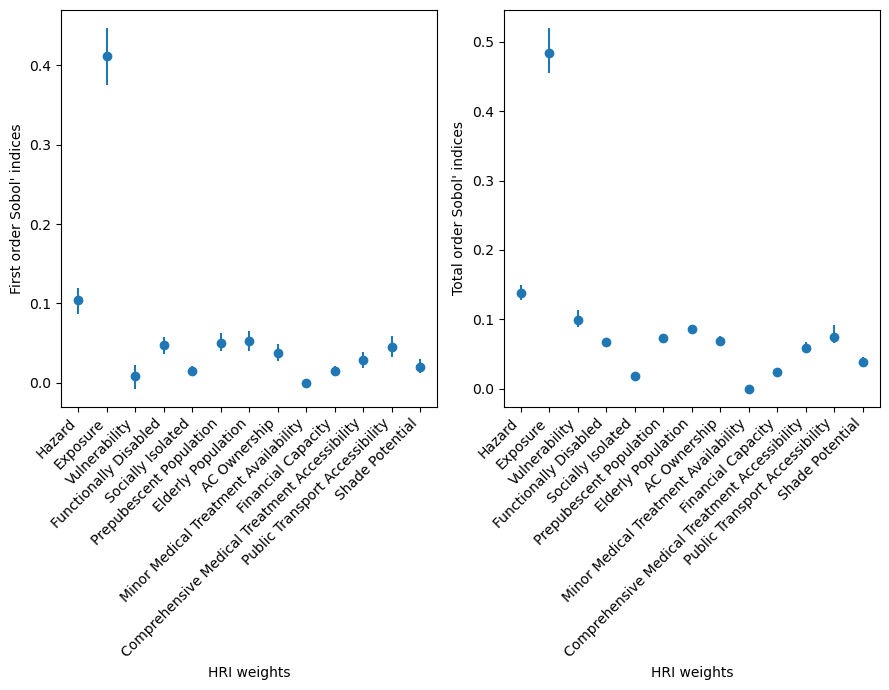

In [200]:
x_labels = ['Hazard','Exposure',"Vulnerability"] + risk_dfs['max_scaling'][norm_type][HRI_time]['Sensitivity'].columns[1:].to_list() + risk_dfs['max_scaling'][norm_type][HRI_time]['Capacity'].columns[1:].to_list()

PlottingUtils.plot_sensitivity_test(res, x_labels=x_labels, figsize=(9,7),
                                    save_fp = os.path.join(r"Exported_Data\exported_figures",
                                                           f"{HRI_time}_global_sensitivity_test.svg"))

In [13]:
import numpy as np
from scipy.stats import sobol_indices, uniform
rng = np.random.default_rng(seed=42) # set seed to ensure consistency in outputs
def f_ishigami(x):
    f_eval = (
        np.sin(x[0])
        + 7 * np.sin(x[1])**2
        + 0.1 * (x[2]**4) * np.sin(x[0])
    )
    return f_eval
indices = sobol_indices(
    func=f_ishigami, n=1024,
    dists=[
        uniform(loc=-np.pi, scale=2*np.pi),
        uniform(loc=-np.pi, scale=2*np.pi),
        uniform(loc=-np.pi, scale=2*np.pi)
    ],
    rng=rng
)
indices.first_order
indices.total_order

array([0.56220596, 0.44494833, 0.24304206])

confidence interval can be obtained using bootstrapping

Visual explanation of Sobol' indices on this function

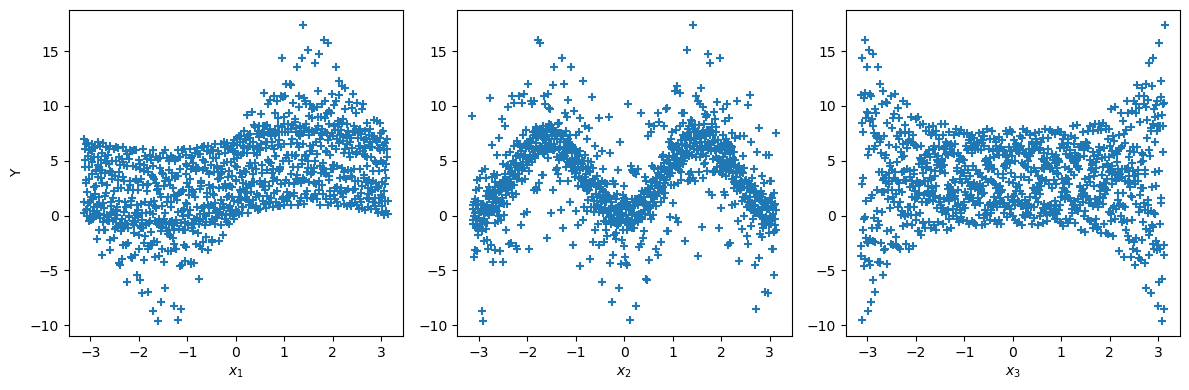

In [31]:
from scipy.stats import qmc
n_dim = 3
p_labels = ['$x_1$', '$x_2$', '$x_3$']
sample = qmc.Sobol(d=n_dim, seed=rng).random(1024)
sample = qmc.scale(
    sample=sample,
    l_bounds=[-np.pi, -np.pi, -np.pi],
    u_bounds=[np.pi, np.pi, np.pi]
)
output = f_ishigami(sample.T)

# scatter plots of the output with respect to each parameter. 
# This gives a visual way to understand how each parameter impacts the output of the function

fig, ax = plt.subplots(1, n_dim, figsize=(12, 4))
for i in range(n_dim):
    xi = sample[:, i]
    ax[i].scatter(xi, output, marker='+')
    ax[i].set_xlabel(p_labels[i])
ax[0].set_ylabel('Y')
plt.tight_layout()
plt.show()